In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [2]:
from src.reference_data import read_sgd_orfs

orfs = read_sgd_orfs()

In [4]:
from src.read_bam import read_mnase_bam

bam_file = '../data/bam/cell_cycle/mnase/DMAH64_MNase_rep1_0_min.bam'
mnase = read_mnase_bam(bam_file, timer=None)


In [5]:
orfs = pd.read_csv('data/orfs_cd_paper_dataset.csv').set_index('orf_name')

In [6]:
computed_p1_positions = pd.read_csv('data/vit/cell_cycle_24x128_p1/computed_+1_positions.csv').set_index('orf_name')

In [7]:
computed_p1_positions.head()

,chr,p1_position
orf_name,,
YAL063C,1,142
YAL062W,1,29
YAL061W,1,-151
YAL060W,1,129
YAL059W,1,28


In [9]:
from src.vit_img_gen import ViTImgGen

# Partitions lengths of fragments into equal sized (length-wise) patches
# Small fragments: 30-79
# Intermediate fragments: 80-129
# Nucleosomal fragments: 130-200
len_cuts = [45, 90, 140, 201]
window = 1024

# Window = 1024
# Resize = 64   (16 downscale)
# Patch size = 4
# 64 / 4 = 16 column patches
# 1024 / 16 = 64 bps per patch
# 12x64 shaped images
patch_size = 8
sublength_resize_height = patch_size # times 3 vertical patches of height
img_width = 128

vit_gen = ViTImgGen(mnase, window, sublength_resize_height, len_cuts,
                    img_width, patch_size, computed_p1_positions=computed_p1_positions)


Loading precomputed +1 nucleosome positions


In [10]:
gene = orfs.loc['YPR119W']

(array([1467.,    0.,  275.,    0.,   70.,    0.,   18.,    0.,   13.,
           5.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

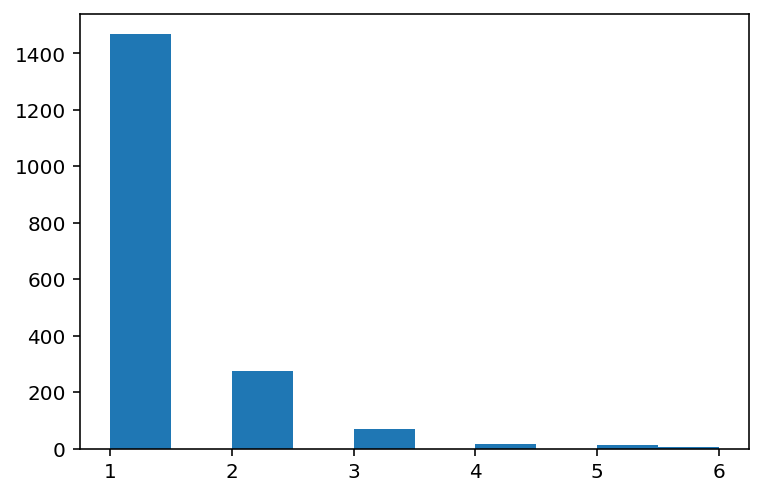

In [23]:
a = img.values.flatten()
plt.hist(a[(a > 0) & (a < 7)])

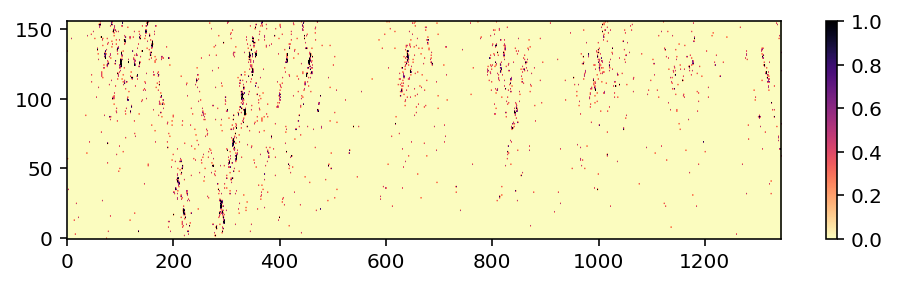

In [33]:
plt.figure(figsize=(8, 2))
plt.imshow(img, vmax=1, origin='lower', cmap='magma_r', aspect='auto')
plt.colorbar()


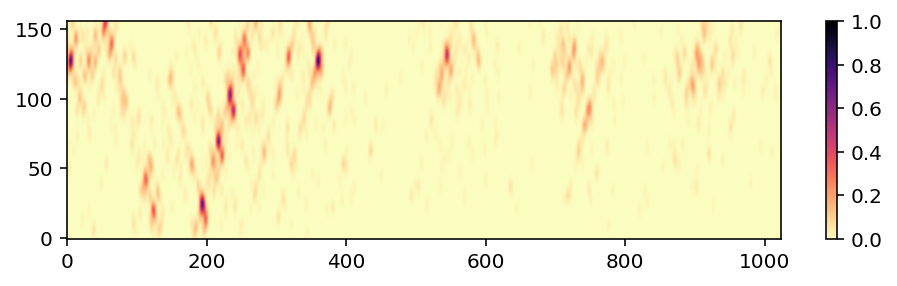

In [34]:
plt.figure(figsize=(8, 2))
plt.imshow(smoothed, vmax=1, origin='lower', cmap='magma_r', aspect='auto')
plt.colorbar()


In [11]:
from src.find_small_plus1 import shift_for_p1

img, scaled_img, smoothed, img_slices, p1 = vit_gen.get_mnase_img(gene)

vit_gen.plot_resized_img(vmax=0.1)

In [65]:
from src.timer import Timer
from config.data_gen import data24x128 as data_config

timer = Timer()

computed_p1_positions = pd.read_csv(f'data/vit/cell_cycle_24x128_p1/computed_+1_positions.csv')\
    .set_index('orf_name')

print("Reading BAM...")
mnase = read_mnase_bam(bam_file, timer=timer, chroms=[gene.chr])
orfs = pd.read_csv('data/orfs_cd_paper_dataset.csv').set_index('orf_name')

# Partitions lengths of fragments into equal sized (length-wise) patches
len_cuts = data_config.LEN_CUTS

cuts = len(len_cuts)-1 # 3
window = data_config.WINDOW

img_height = data_config.IMG_HEIGHT
img_width = data_config.IMG_WIDTH

patch_size = img_height // cuts
sublength_resize_height = patch_size # times 3 vertical patches of height

vit_gen = ViTImgGen(mnase, window, sublength_resize_height, len_cuts,
                    img_width, patch_size, computed_p1_positions=computed_p1_positions)
imgs = np.zeros((len(orfs), img_height, img_width))
p1_poses = np.zeros((len(orfs),))
i = 0

print({"img_size": (img_height, img_width),
             "window": window,
             "length_cuts": len_cuts,
             "patch_size": patch_size,
             "img_height": img_height,
             "img_width": img_width})

print("Generating MNase images...")

for chrom in [gene.chr]:

    chrom_mnase = mnase[mnase.chr == chrom]
    chrom_orfs = orfs[orfs.chr == chrom]

    orf_name, orf = gene.name, gene
    img, img_t, smoothed, img_slices, p1_pos = vit_gen.get_mnase_img(orf)
    imgs[i] = img_t
    p1_poses[i] = p1_pos

    i += 1

    timer.print_progress(i, len(orfs), every=100)


Reading BAM...
Chromosome 16 - 00:00:00.01
Loading precomputed +1 nucleosome positions
{'img_size': (24, 128), 'window': 1024, 'length_cuts': [45, 90, 140, 201], 'patch_size': 8, 'img_height': 24, 'img_width': 128}
Generating MNase images...


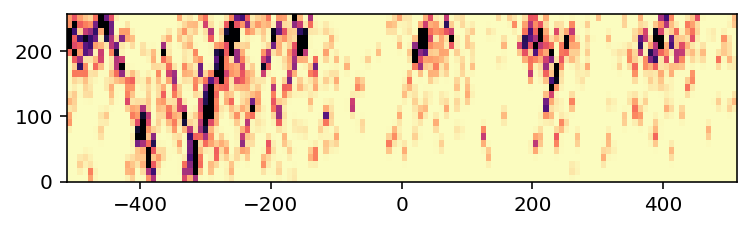

In [66]:
plt.imshow(img_t, cmap='magma_r', vmax=0.1, origin='lower', extent=[-512, 512, 0, 256])

In [67]:
ret = read_pickle('data/vit/cell_cycle_24x128_p1/vit_imgs_24x128_DMAH64_MNase_rep1_0_min.pkl')

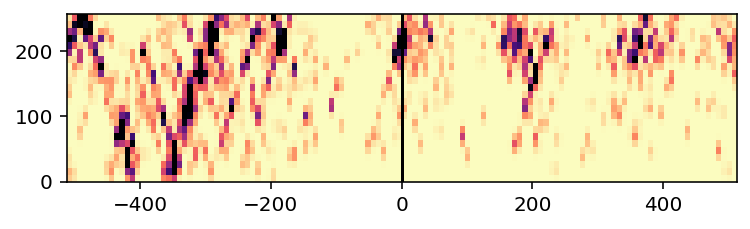

In [73]:
from src.utils import read_pickle
ret_img = ret[1][4371]
plt.imshow(ret_img[0], cmap='magma_r', vmax=0.1, origin='lower', extent=[-512, 512, 0, 256])
plt.axvline(0, c='black')